In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import pickle
import sys
from keras.models import load_model
from keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import seaborn as sn

Using TensorFlow backend.


In [2]:
thisPath = os.getcwd()
os.chdir("../../code")
projectDir = os.getcwd()
from evalUtils import plotModelHist, UrgentVRoutne, reportBinaryScores

In [3]:
from evalUtils import plotModelHist, UrgentVRoutne, reportBinaryScores

In [4]:
yTestPath1 = r"D:\Projects\OCT-Image-Classification\PreprocessedData\preprocessedForCNN\224x224\targetData_(224, 224, 3)_test.npy"
yTrueTest224 = np.load(yTestPath1)

In [5]:
yTestPath2 = r"D:\Projects\OCT-Image-Classification\PreprocessedData\preprocessedForCNN\299x299\targetData_(299, 299, 3)_test.npy"
yTrueTest299 = np.load(yTestPath2)

In [5]:
modelsPath = r"D:\Projects\OCT-Image-Classification\modelOutput\compareModels3"
InceptionPath = r"InceptionV3_dataAug_False2019-06-01_20_41_default"
ResNet50Path = r"ResNet50_dataAug_False2019-06-01_18_31_default" 
VGG16Path = r"VGG16_dataAug_False2019-06-05_15_46_default_224_noprep" 
XceptionPath = r"Xception_dataAug_False2019-06-02_10_52_default"

In [7]:
dirList = [VGG16Path, ResNet50Path, InceptionPath, XceptionPath] #
modelNames = ["VGG16", "ResNet50", "InceptionV3", "Xception"] #
yLblsUnique = np.unique(yTrueTest299)
modelPred = {}
modelPredDF = pd.DataFrame()
for i, (expDir, modelName) in enumerate(zip(dirList, modelNames)):
    print(i, expDir)
    expPath = join(modelsPath, expDir)
    assert(os.path.isdir(expPath))
    histPath = join(expPath, "{}_History.csv".format(modelName)) 
    modelHist = pd.read_csv(histPath, index_col=0)
    plotModelHist(modelHist)
    
    yTestPredDF = pd.read_csv(join(expPath, "yPredDf__testSet_.csv"), index_col=0)
    modelPredDF.join(yTestPredDF)
    
    if modelName == "VGG16":
        print('loading yTestPred')
        yTestPred = np.load(join(expPath, "yTestPred.npy"))
    else:
        print('loading yPred__testSet_')
        yTestPred = np.load(join(expPath, "yPred__testSet_.npy"))
        for yLbl in yLblsUnique:
            modelPredDF[modelName  +"_{}".format(yLbl)] = yTestPred[:, yLbl]
    modelPred[modelName] = yTestPred

    
#modelPredDF['yTrueLbls'] = yTrueTest299
#modelPredDF.to_csv(join(thisPath, 'modelPredictions.csv'))

NameError: name 'yTrueTest299' is not defined

In [7]:
classMap = {
    "NORMAL": 0,
    "DRUSEN": 1,
    "CNV": 2,
    "DME": 3}





In [84]:
AccListVGG16 = []
SensListVGG16 = []
SpecListVGG16 = []

aucListVGG16 = []
fprsListVGG16 = []
tprsListVGG16 = []

metricDict = {}
for model_i in modelPred.keys():
    print(model_i)
    if model_i == "VGG16":
        print('vgg yPred')
        yTrueTest = yTrueTest224
    else:
        yTrueTest = yTrueTest299

    yTrue1Hot = to_categorical(yTrueTest)
    yTrueTestUrgent = UrgentVRoutne(yTrue1Hot, classMap).astype(np.int)
    
    yTestPred = modelPred[model_i]
    classAcc = accuracy_score(yTrueTest,
                              yTestPred.argmax(axis=1))
    print('\t accuracy: {0:.3g}'.format(classAcc))
    yTestPredUrgent = UrgentVRoutne(yTestPred, classMap)
    print()
    print('\t binary (urgent vs non-urgent)')
    scores = reportBinaryScores(yTrueTestUrgent, yTestPredUrgent, v=1)
    acc, tpr, tnr, plr, nlr = scores
    
    fprs, tprs, _ = roc_curve(yTrueTestUrgent, yTestPredUrgent)
    aucUrgent = auc(fprs, tprs)
    print('\t auc {0:.3g}'.format(aucUrgent))
    metricDict[model_i] = {}
    metricDict[model_i]["acc"] = acc
    metricDict[model_i]["tpr"] = tpr
    metricDict[model_i]["tnr"] = tnr
    metricDict[model_i]["aucUrgent"] = aucUrgent
    metricDict[model_i]["fprs"] = fprs
    metricDict[model_i]["tprs"] = tprs
    
    #print(classAcc, acc)
    AccListVGG16.append(acc)
    SensListVGG16.append(tpr)
    SpecListVGG16.append(tnr)
    
    aucListVGG16.append(aucUrgent)
    fprsListVGG16.append(fprs)
    tprsListVGG16.append(tprs)
    #if model_i == "ResNet50":
    #    break
    del yTrueTest

VGG16
vgg yPred
	 accuracy: 0.894

	 binary (urgent vs non-urgent)
	 accuracy: 0.924
	 sensitivity 0.932
	 specificity 0.915
	 positive likelihood ratio 11
	 negative likelihood ratio 0.0745


	 auc 0.974
ResNet50
	 accuracy: 0.896

	 binary (urgent vs non-urgent)
	 accuracy: 0.928
	 sensitivity 0.93
	 specificity 0.926
	 positive likelihood ratio 12.5
	 negative likelihood ratio 0.0759


	 auc 0.976
InceptionV3
	 accuracy: 0.903

	 binary (urgent vs non-urgent)
	 accuracy: 0.944
	 sensitivity 0.959
	 specificity 0.93
	 positive likelihood ratio 13.6
	 negative likelihood ratio 0.0444


	 auc 0.989
Xception
	 accuracy: 0.957

	 binary (urgent vs non-urgent)
	 accuracy: 0.969
	 sensitivity 0.965
	 specificity 0.973
	 positive likelihood ratio 35.9
	 negative likelihood ratio 0.0361


	 auc 0.997


In [72]:
for y, yp, yb, ypb in zip(yTrueTest, yTestPred, yTestPredUrgent):
    print(y, yp)

3 [2.0744485e-06 2.5370842e-05 3.4424693e-03 9.9653012e-01]
3 [2.5158624e-06 2.1383512e-08 2.5419133e-06 9.9999499e-01]
1 [8.9110814e-05 9.9716812e-01 1.5161440e-03 1.2265750e-03]
3 [1.2038997e-01 2.0145855e-03 6.1046907e-05 8.7753433e-01]
1 [6.3270237e-04 9.9634320e-01 2.1568248e-04 2.8084249e-03]
2 [5.0968077e-07 3.0584687e-03 9.9691749e-01 2.3471392e-05]
3 [9.8317391e-01 1.6554037e-02 2.4828840e-05 2.4721230e-04]
1 [0.00524466 0.9143547  0.04314442 0.03725624]
3 [9.9453342e-01 2.6933560e-03 1.0272624e-04 2.6704215e-03]
2 [5.4816173e-08 1.4974037e-02 9.7593147e-01 9.0944776e-03]
1 [0.2311382  0.7581647  0.00437694 0.00632019]
0 [0.36309758 0.62406063 0.00089496 0.01194685]
2 [1.4528015e-09 8.3278064e-07 9.9960858e-01 3.9057506e-04]
0 [9.9543387e-01 1.9073242e-04 2.3159960e-06 4.3731267e-03]
2 [2.1759357e-05 2.0121604e-02 9.7840071e-01 1.4559529e-03]
2 [1.14565855e-05 5.07629454e-01 4.91478354e-01 8.80759966e-04]
2 [1.7383389e-05 3.4521431e-01 6.5467227e-01 9.5983298e-05]
2 [5.4062070

1 [5.3391665e-05 9.9986589e-01 5.3520998e-05 2.7200367e-05]
1 [3.0541493e-04 9.8953933e-01 9.9914568e-03 1.6376456e-04]
3 [0.00134963 0.35765886 0.0109019  0.63008964]
1 [7.4680877e-04 9.9923015e-01 1.9876288e-06 2.1041578e-05]
0 [9.9778420e-01 2.0427338e-03 6.1972814e-06 1.6687840e-04]
1 [4.2110792e-04 6.0634047e-01 3.1652966e-01 7.6708756e-02]
0 [9.9994576e-01 9.4434936e-06 4.6637705e-08 4.4796143e-05]
0 [8.4413074e-02 4.4081085e-03 6.4920087e-06 9.1117233e-01]
2 [1.6081760e-06 2.5825885e-03 9.9728417e-01 1.3156481e-04]
1 [2.1173605e-06 9.8917538e-01 9.6093761e-03 1.2130579e-03]
1 [2.6572734e-06 9.9628013e-01 3.4869530e-03 2.3032122e-04]
2 [2.9624478e-05 6.7365868e-03 6.1739659e-01 3.7583712e-01]
1 [5.0339554e-03 9.9267560e-01 1.3838798e-03 9.0664229e-04]
2 [9.8805754e-07 2.0255286e-06 9.9985147e-01 1.4552970e-04]
1 [6.2713656e-07 9.8367912e-01 1.4303835e-02 2.0164005e-03]
2 [1.5356231e-07 2.7690755e-06 9.9956709e-01 4.2996148e-04]
1 [6.9449487e-04 7.2670084e-01 2.6349255e-01 9.11208

In [85]:
metricsDF = pd.DataFrame(index=modelPred.keys(), columns=['acc', 'tpr', 'tnr', 'auc'])
metricsDF["acc"] = AccListVGG16
metricsDF["tpr"] = SensListVGG16
metricsDF["tnr"] = SpecListVGG16
metricsDF["auc"] = aucListVGG16


In [86]:
metricsDF

,acc,tpr,tnr,auc
VGG16,0.923554,0.931818,0.915289,0.973670
ResNet50,0.927686,0.929752,0.925620,0.976346
InceptionV3,0.944215,0.958678,0.929752,0.989225
Xception,0.969008,0.964876,0.973140,0.997366


In [87]:
reportedAcc = 0.934
reportedSens = 0.966
reportedSpec = 0.94
reportedAuc = 0.988

reportedMetrics = [reportedAcc, 
                   reportedSens, 
                   reportedSpec,
                   reportedAuc]

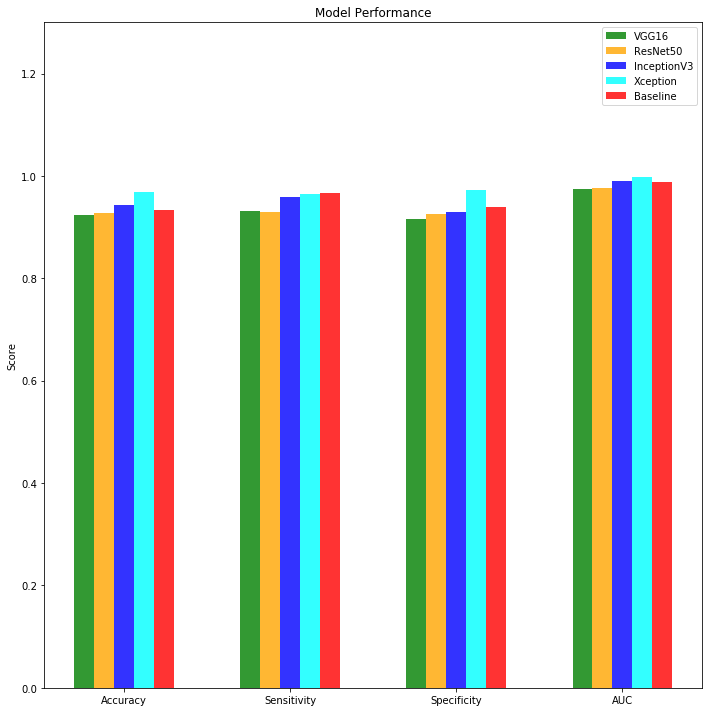

In [88]:
opacity = 0.8
error_config = {'ecolor': '0.3'}
n_groups = 4
nModels = len(modelPred.keys()) + 1

fig, ax = plt.subplots(figsize=(10, 10))
index = np.arange(n_groups)
bar_width = 0.12
colors = ['green', 'orange', 'blue', 'cyan']
for i, (vgg_i, c) in enumerate(zip(modelPred.keys(), colors)):
    
    xpos = index - nModels*bar_width/2 + (i+1)*bar_width
    rectsi = ax.bar(xpos, 
                    metricsDF.loc[vgg_i], bar_width,
                    alpha=opacity, color=c,
                    label=vgg_i)

xpos = index - nModels*bar_width/2 + (i+2)*bar_width
rects2 = ax.bar(xpos, reportedMetrics, bar_width,
                alpha=opacity, color='r', 
                label='Baseline')

#ax.set_xlabel('Group')
ax.set_ylabel('Score')
ax.set_title('Model Performance')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Accuracy', 'Sensitivity', 'Specificity', 'AUC'))
ax.set_ylim([0.0, 1.3])
ax.legend()

fig.tight_layout()
plt.show()
    